In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
repo=os.environ['LYA_EMU_REPO']
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir=repo+"/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","n_p","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
simnum=101

In [5]:
archive=p1d_arxiv.ArxivP1D(basedir=basedir,nsamples=199,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

## Now want to train an emulator on all 200 sims, and use those hyperparameters and
## param scalings to use 199 points and predict the 1 remaining
full_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

emu_full=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1584 points
Optimised
Training GP on 1600 points
Optimised


In [13]:
emu.gp.param_array
#emu_full.gp.param_array
#print(emu.paramLimits)
#print(emu_full.paramLimits)

array([1.81689167e+01, 4.54618808e+01, 6.23040438e-01, 1.17601187e-02])

In [10]:
emu_fullparam=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)
emu_fullparam.paramLimits=emu_full.paramLimits
emu_fullparam.load_hyperparams(emu_full.gp.param_array)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


[-2.32726365e-04  3.51403383e-05  1.79690800e-04  1.98922807e-04
  2.35040084e-04  2.31518630e-04  2.18843306e-04  1.97781048e-04
  1.96560827e-04  1.73882037e-04  1.56980470e-04  1.57172208e-04
  1.33027965e-04  1.33026402e-04  1.23108514e-04  1.08651802e-04
  1.02484875e-04  8.70234114e-05  8.80940710e-05  7.65848111e-05
  7.62173841e-05  6.15124077e-05  6.21108725e-05  5.25718511e-05
  5.17776810e-05  4.46421990e-05  4.29553856e-05  3.74617710e-05]
[1.29630394e-04 3.19089727e-04 3.90134141e-04 3.82217232e-04
 3.77342280e-04 3.49231843e-04 3.19628461e-04 2.94824762e-04
 2.73145759e-04 2.43056101e-04 2.23415073e-04 2.14881810e-04
 1.93143975e-04 1.84590123e-04 1.66836243e-04 1.52621925e-04
 1.45891786e-04 1.29266840e-04 1.23051733e-04 1.12484088e-04
 1.04630726e-04 9.25894070e-05 8.98535637e-05 7.68125572e-05
 7.37604785e-05 6.61347509e-05 6.03530713e-05 5.44330024e-05]
[1.38273839e-04 2.81551695e-04 3.17682049e-04 3.20820785e-04
 3.03638270e-04 2.74359062e-04 2.50760621e-04 2.3219728

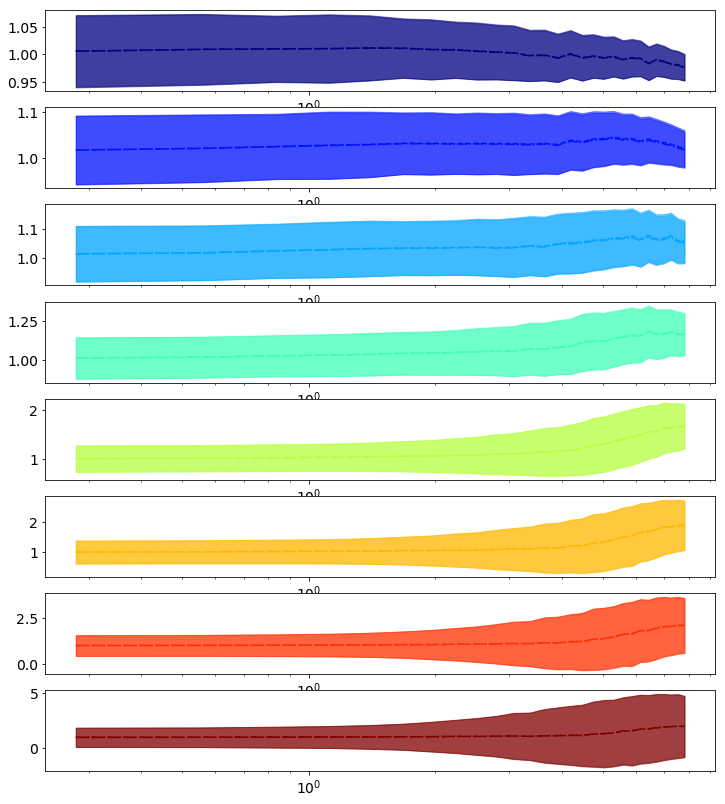

In [15]:
## Compare predictions for the two sets of hyperparams.. should be v similar!
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    
    pred_single,err_single=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_split,err_split=emu_fullparam.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    print(pred_single-pred_split)
    ## Plot z with different limits
    plt.plot(k_test,pred_single/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed")
    plt.fill_between(k_test,(pred_single+np.sqrt(np.diag(err_single)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_single-np.sqrt(np.diag(err_single)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    ## Plot z with same limits
    plt.plot(k_test,pred_split/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="-.")
    plt.fill_between(k_test,(pred_split+np.sqrt(np.diag(err_split)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_split-np.sqrt(np.diag(err_split)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.xscale("log")
